# **Redes neuronales convolucionales**
## **Carlos Garavito**
***
En este cuaderno, entrenamos una red neuronal convolucional **CNN** para classificar imágenes del dataset CIFAR-10.

Las imágenes en esta base de datos son imágenes pequeñas a color que caen en una de 10 clases: avión, automóvil, pájaro, gato, reno, perro, sapo, caballo, oveja, camión.

### Revisar [CUDA](http://pytorch.org/docs/stable/cuda.html)

Dado el tamaño de las imágenes, puede ser útil agilizar el entrenamiento, mediante el uso de GPU. CUDA es una plataforma de computación paralela. Revisamos abajo si está activado el modo GPU. De lo contrario vamos a "Entorno de ejecución" y luego "Cambiar tipo de entorno de ejecución".

In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Cargar los [Datos](http://pytorch.org/docs/stable/torchvision/datasets.html)

Cargamos los datos de Train y Test, partimos el conjunto Train nuevamente en Training y Validation set. Luego creamos Dataloaders para cada uno de esos conjuntos.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualización de un *Batch* o lote del conjunto de entrenamiento.

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
from google.colab import output
output.disable_custom_widget_manager()

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

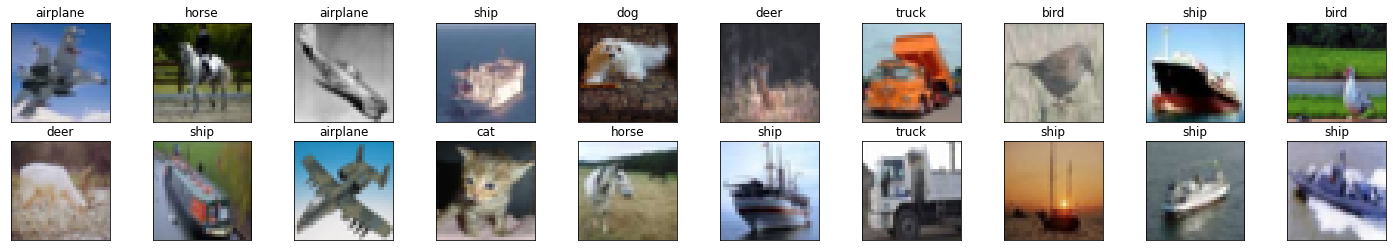

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Ver la imagen con más detalle

Aquí observamos los canales de colores (rojo, verde y azul RGB) como tres imágenes separadas de intensidad en escala de grices.

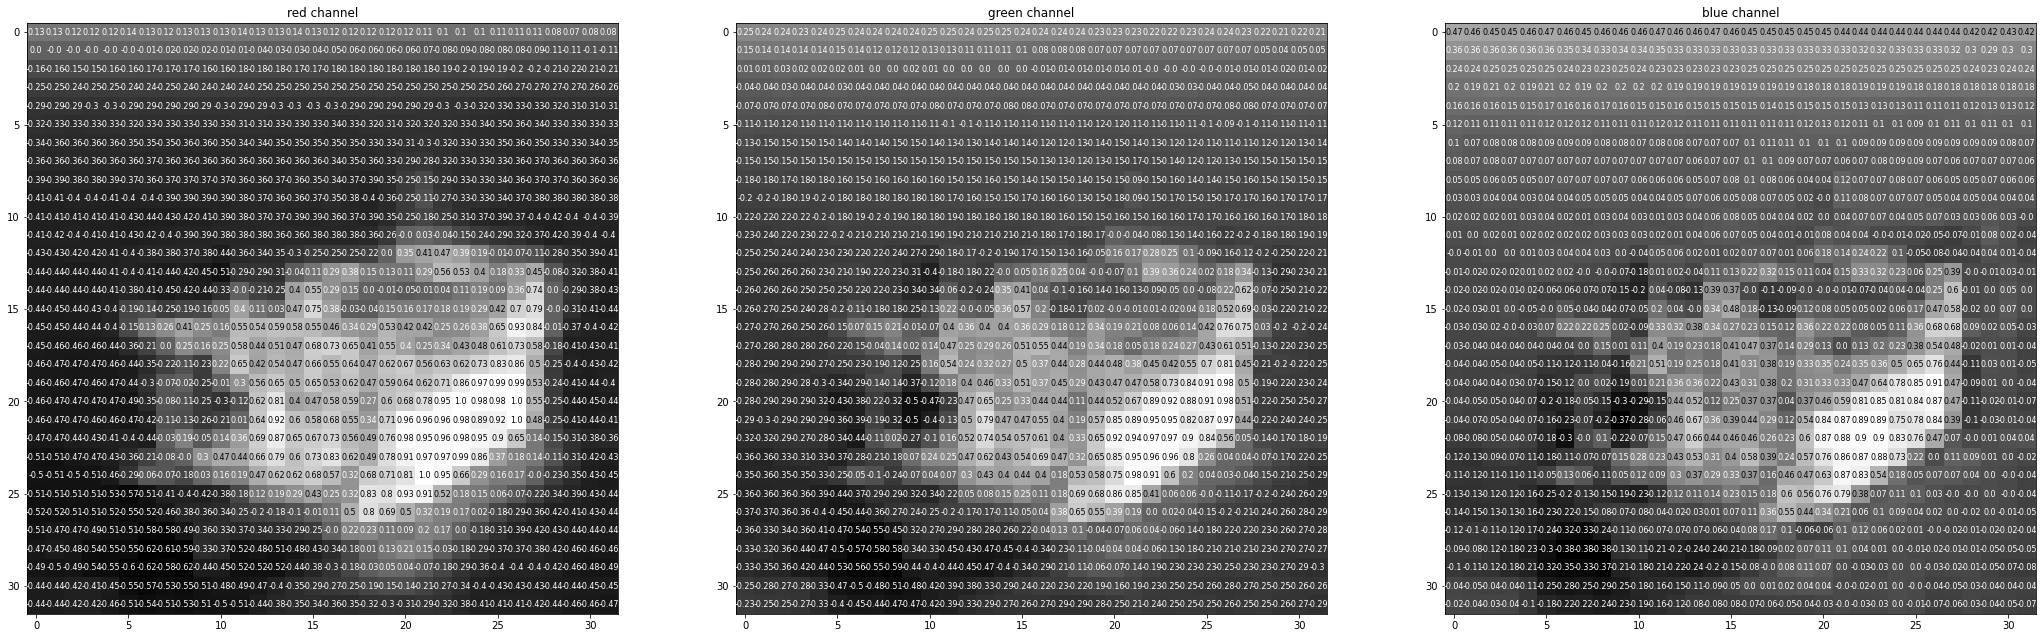

In [8]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Definición de la [architectura](http://pytorch.org/docs/stable/nn.html)de la red neruonal convolucional.

Usted definirá una arquitectura de red neuronal convolucional CNN. Deberá usar lo siguiente:

* [Capas convolucionales](https://pytorch.org/docs/stable/nn.html#conv2d), que se pueden pensar como pilas de imágenes filtradas.
* [Capas de Maxpooling](https://pytorch.org/docs/stable/nn.html#maxpool2d), 
que reducen las dos dimensiones de una entrada, conservando sólo los pixeles más *activos* de la capa anterior.
* La capa lineal usual y capa de Dropput, para evitar el sobreajuste y producir una salida de 10 dimensiones.

Se provee un código inicial con una capa convolucional y una de maxpooling.

#### TO_DO: Defina un modelo con múltiples capas convolucionales, y defina el paso Feedforward.

Entre más capas convolucionales incluya, más complejos serán los patrones de color y forma que el modelo puede detectar. Se sugiere que su modelo final incluya 2 o 3 capas convolucionales, así como capas lineales y de dropout para evitar el sobreajuste. Use funciones de activación como Relu (Ver cuaderno anterior).

#### Dimensiones de salida de una capa convolucional:

Para calcular las dimensiones de salida de una capa convolucional podemos llevar a cabo el siguiente cálculo. (tomade de [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

Por ejemplo, para una entrada de 7x7 y un filtro (kernel) de tamaño 3x3, con stride 1 y padding 0, obtendríamos una salida de 5x5. Con stride 2, obtendríamos salida de 3x3.

In [216]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convolutional layer
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    # max pooling layer
    self.pool = nn.MaxPool2d(2, 2)
    # fully connected layers
    self.fc1 = nn.Linear(64 * 4 * 4, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 10)
    # dropout
    self.dropout = nn.Dropout(p=.5)

  def forward(self, x):
    #TO_DO añadir una secuencia de capas, con las indicaciones dadas.
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    # flattening
    x = x.view(-1, 64 * 4 * 4)
    # fully connected layers
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [225]:
# output_W calculator
n = 8
K = 2
P = 0
S = 2

n_new = ((n - K + 2*P)/S) + 1
print(n_new)

4.0


### Especificar [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) y el [Optimizador](http://pytorch.org/docs/stable/optim.html)

Elija una función de costo y optimizador que se ajuste a ésta tarea de clasificación. Un buen punto de partida puede ser [éste ejemplo de clasificación.](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) o el cuaderno anterior. 

#### TO_DO: Definir la función de costo y el optimizador, y observe (puede ser imprimiendo el Training Loss y Validation Loss en cada iteración) cómo ésta elección cambia el costo o error a través del tiempo.
> Se incluye la gráfica de cambio en el tiempo al finalizar el entranmiento de la red. 

In [218]:
import torch.optim as optim

# Especificar función de costo
criterion = nn.CrossEntropyLoss()

# Especificar optimizador
optimizer = optim.SGD(model.parameters(), lr=0.001)

---
## Entrenar la red neuronal

Recuerde observar cómo el error de entrenamiento y validación decrece con el tiempo. Si el error de validación alguna vez crece, ésto indica un posible sobreajuste. 

Epoch: 1 	Training Loss: 1.327855 	Validation Loss: 0.314765
Validation loss decreased (inf --> 0.314765).  Saving model ...
Epoch: 2 	Training Loss: 1.311608 	Validation Loss: 0.310675
Validation loss decreased (0.314765 --> 0.310675).  Saving model ...
Epoch: 3 	Training Loss: 1.301085 	Validation Loss: 0.307345
Validation loss decreased (0.310675 --> 0.307345).  Saving model ...
Epoch: 4 	Training Loss: 1.286634 	Validation Loss: 0.304790
Validation loss decreased (0.307345 --> 0.304790).  Saving model ...
Epoch: 5 	Training Loss: 1.277164 	Validation Loss: 0.300103
Validation loss decreased (0.304790 --> 0.300103).  Saving model ...
Epoch: 6 	Training Loss: 1.262400 	Validation Loss: 0.296855
Validation loss decreased (0.300103 --> 0.296855).  Saving model ...
Epoch: 7 	Training Loss: 1.251736 	Validation Loss: 0.295000
Validation loss decreased (0.296855 --> 0.295000).  Saving model ...
Epoch: 8 	Training Loss: 1.241422 	Validation Loss: 0.291469
Validation loss decreased (0.29500

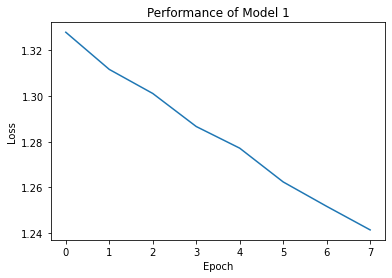

In [233]:
# number of epochs to train the model
n_epochs = 8
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)    
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

plt.plot(list(range(n_epochs)), train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()


###  Cargar el modelo con el menor error de validación.

In [211]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

---
## Testear la red neuronal entrenada.

Testear su modelo en datos no procesados anteriormente. Un "Buen" resultado será una CNN que obtenga alrededor de 70% (o más, intente lo mejor!) de precisión en éstas imágenes de test.

In [212]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.321339

Test Accuracy of airplane:  0% ( 0/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer:  0% ( 0/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog:  0% ( 0/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship: 100% (1000/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)


### TO_DO: 
. Explicar en detalle lo que ocurre en cada capa, y la razón por la cuál se obtienen los tamaños de cada imagen procesada. De manera similar a como vimos en clase.
Qué dimensiones de tensor entra en cada capa?
Qué parámetros tiene la capa convolucional?
Qué dimensiones tiene el tensor de salida de cada capa? 
Por qué se obtuvieron esos tamaños?

> El comportamiento y las dimensiones resultantes de cada capa se visualizan en el diagrama. La dimensiones en cada capa, corresponden a la cantidad de canales definidos en cada capa de convolución y las dimensiones obtenidas según el cáculo ` ((n - K + 2*P)/S) + 1`. 

![](cnn.png)


### TO_DO: ¿Cuáles son las debilidades de su modelo y cómo podrían ser mejoradas?

> El modelo todavía tiene un error muy grande. Esto es porque la arquitectura de la red todavía no es lo suficientemente eficiente para clasificar correctamente. Para solucionar esto, se podria implementar otra tipo de red más compleja, que tenga más capas internas. Una solución, es implementar contenedores de capas, como se muestra en este [blog](https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844).


### Visualizar resultados para muestra del Test Set

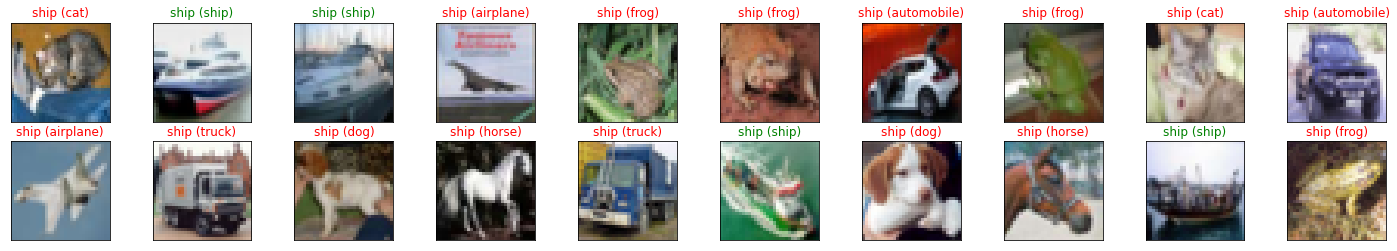

In [213]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
  images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx].cpu())
  ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                color=("green" if preds[idx]==labels[idx].item() else "red"))